In [96]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import TensorBoard, LearningRateScheduler, ReduceLROnPlateau

import h5py
from sklearn.utils import shuffle

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
path = '/output/dogscats/'
#sample_path = '/output/dogscats/sample'
batch_size = 32

In [3]:
def write_gap(MODEL, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory(path+'train', image_size, shuffle=False, 
                                              batch_size=batch_size)
    valid_generator = gen.flow_from_directory(path+'valid', image_size, shuffle=False, 
                                              batch_size=batch_size)
    test_generator = gen.flow_from_directory(path+'test', image_size, shuffle=False, 
                                             batch_size=batch_size, class_mode=None)

    train = model.predict_generator(train_generator, train_generator.nb_sample)
    valid = model.predict_generator(valid_generator, valid_generator.nb_sample)
    test = model.predict_generator(test_generator, test_generator.nb_sample)
    with h5py.File("gap_%s.h5"%MODEL.__name__) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("valid", data=valid)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)
        h.create_dataset("val_label", data=valid_generator.classes)

Precompute features

In [4]:
%time write_gap(ResNet50, (224, 224))

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
CPU times: user 9min 44s, sys: 46.4 s, total: 10min 31s
Wall time: 15min 58s


Load precomputed data

In [5]:
X_train = []
X_valid = []
X_test = []

for filename in ["gap_ResNet50.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_valid.append(np.array(h['valid']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])
        y_valid = np.array(h['val_label'])

X_train = np.concatenate(X_train, axis=1)
X_valid = np.concatenate(X_valid, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

In [54]:
"""
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.8)(x)
x = Dense(1, activation='sigmoid')(x)
model_rmsprop = Model(input_tensor, x)
model_adam = Model(input_tensor, x)
model_nadam = Model(input_tensor, x)
model_sgd = Model(input_tensor, x)
model_sgdnes = Model(input_tensor, x)

#tb_callbacks = TensorBoard(log_dir='/output/dogscats/logs', histogram_freq=0, write_graph=True, write_images=True)
#learning_rates = np.linspace(3e-3, 1e-5, 50)
#lr_callbacks = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))

from keras.optimizers import Nadam, Adam, SGD
model_rmsprop.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model_adam.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model_nadam.compile(optimizer=Nadam(), loss='binary_crossentropy', metrics=['accuracy'])
model_sgd.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model_sgdnes.compile(optimizer=SGD(nesterov=True), loss='binary_crossentropy', metrics=['accuracy'])
"""

**Reduce learning rate when 'val_loss' has stopped improving.**

In [99]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

**Optimizer 1: RMSprop**

In [114]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model_rmsprop = Model(input_tensor, x)
model_rmsprop.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
hist_rmsprop = model_rmsprop.fit(X_train, y_train, batch_size=batch_size*2, 
                  nb_epoch=300, validation_data=(X_valid,y_valid), verbose=0, callbacks=[reduce_lr])

**Optimizer 2: Adam**

In [115]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model_adam = Model(input_tensor, x)
model_adam.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
hist_adam = model_adam.fit(X_train, y_train, batch_size=batch_size*2, 
               nb_epoch=300, validation_data=(X_valid,y_valid), verbose=0, callbacks=[reduce_lr])

**Optimizer 3: Nadam**

In [116]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model_nadam = Model(input_tensor, x)
model_nadam.compile(optimizer=Nadam(), loss='binary_crossentropy', metrics=['accuracy'])
hist_nadam = model_nadam.fit(X_train, y_train, batch_size=batch_size*2, 
                nb_epoch=300, validation_data=(X_valid,y_valid), verbose=0, callbacks=[reduce_lr])

**Optimizer 4: SGD**

In [111]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model_sgd = Model(input_tensor, x)
model_sgd.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
hist_sgd = model_sgd.fit(X_train, y_train, batch_size=batch_size*2, 
              nb_epoch=300, validation_data=(X_valid,y_valid), verbose=0, callbacks=[reduce_lr])

**Optimizer 5: SGD + Nesterov**

In [117]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model_sgdnes = Model(input_tensor, x)
model_sgdnes.compile(optimizer=SGD(nesterov=True), loss='binary_crossentropy', metrics=['accuracy'])
hist_sgdnes = model_sgdnes.fit(X_train, y_train, batch_size=batch_size*2, 
              nb_epoch=300, validation_data=(X_valid,y_valid), verbose=0, callbacks=[reduce_lr])

**Optimizer 6: SGD with momentum=0.9**

In [118]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model_sgdmo = Model(input_tensor, x)
model_sgdmo.compile(optimizer=SGD(momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
hist_sgdmo = model_sgdmo.fit(X_train, y_train, batch_size=batch_size*2, 
              nb_epoch=300, validation_data=(X_valid,y_valid), verbose=0, callbacks=[reduce_lr])

**Optimizer 7: SGD + Nesterov with momentum=0.9 **

In [142]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model_sgdmones = Model(input_tensor, x)
model_sgdmones.compile(optimizer=SGD(momentum=0.9, nesterov=True), loss='binary_crossentropy', metrics=['accuracy'])
hist_sgdmones = model_sgdmones.fit(X_train, y_train, batch_size=batch_size*2, 
              nb_epoch=300, validation_data=(X_valid,y_valid), verbose=0, callbacks=[reduce_lr])

# Visualize Acc. & Loss#

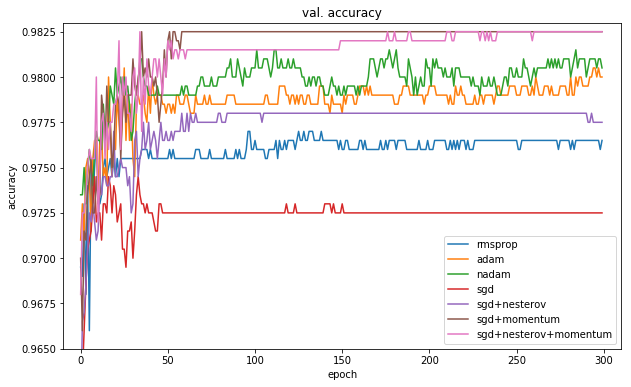

In [173]:
plt.figure(figsize=(10, 6))  
plt.axis((-10,310,0.965,0.983))

plt.plot(hist_rmsprop.history['val_acc'])
plt.plot(hist_adam.history['val_acc'])
plt.plot(hist_nadam.history['val_acc'])
plt.plot(hist_sgd.history['val_acc'])
plt.plot(hist_sgdnes.history['val_acc'])
plt.plot(hist_sgdmo.history['val_acc'])
plt.plot(hist_sgdmones.history['val_acc'])
plt.title('val. accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['rmsprop', 'adam', 'nadam', 'sgd', 'sgd+nesterov', 'sgd+momentum', 'sgd+nesterov+momentum'], loc='lower right')  

plt.show()

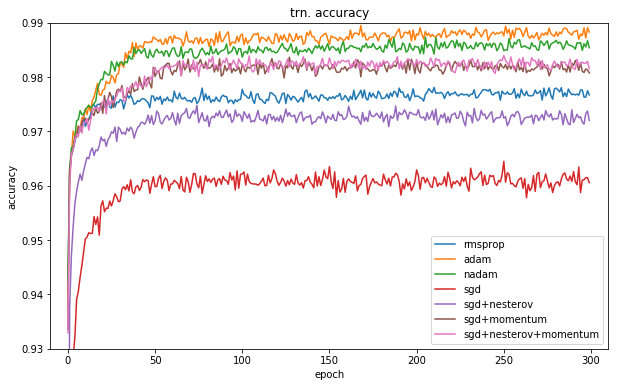

In [166]:
plt.figure(figsize=(10, 6))  
plt.axis((-10,310,0.93,0.99))

plt.plot(hist_rmsprop.history['acc'])  
plt.plot(hist_adam.history['acc'])  
plt.plot(hist_nadam.history['acc']) 
plt.plot(hist_sgd.history['acc']) 
plt.plot(hist_sgdnes.history['acc']) 
plt.plot(hist_sgdmo.history['acc'])
plt.plot(hist_sgdmones.history['acc'])
plt.title('trn. accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['rmsprop', 'adam', 'nadam', 'sgd', 'sgd+nesterov', 'sgd+momentum', 'sgd+nesterov+momentum'], loc='lower right')  

plt.show()

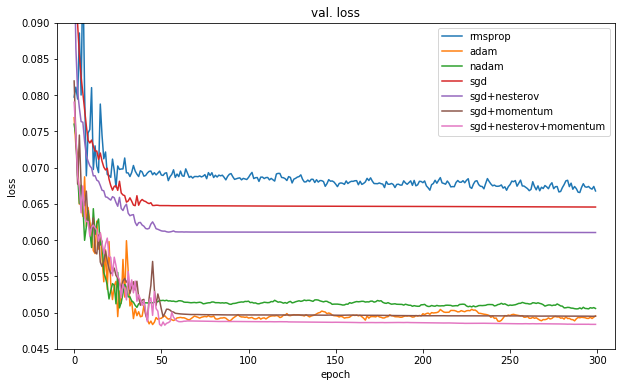

In [162]:
plt.figure(figsize=(10, 6))  
plt.axis((-10,310,0.045,0.09))

plt.plot(hist_rmsprop.history['val_loss'])  
plt.plot(hist_adam.history['val_loss'])  
plt.plot(hist_nadam.history['val_loss']) 
plt.plot(hist_sgd.history['val_loss']) 
plt.plot(hist_sgdnes.history['val_loss']) 
plt.plot(hist_sgdmo.history['val_loss'])
plt.plot(hist_sgdmones.history['val_loss'])
plt.title('val. loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['rmsprop', 'adam', 'nadam', 'sgd', 'sgd+nesterov', 'sgd+momentum', 'sgd+nesterov+momentum'], loc='upper right')  

plt.show()

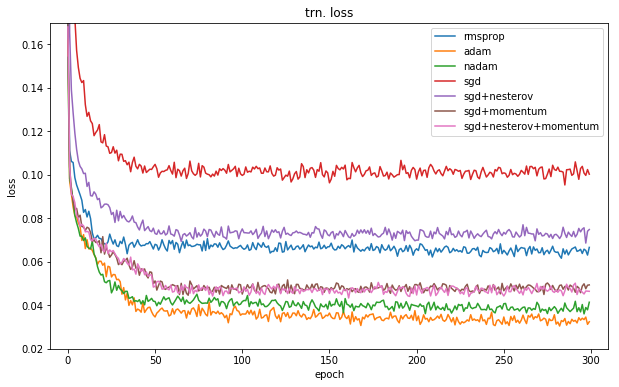

In [164]:
plt.figure(figsize=(10, 6))  
plt.axis((-10,310,0.02,0.17))

plt.plot(hist_rmsprop.history['loss'])  
plt.plot(hist_adam.history['loss'])  
plt.plot(hist_nadam.history['loss']) 
plt.plot(hist_sgd.history['loss']) 
plt.plot(hist_sgdnes.history['loss']) 
plt.plot(hist_sgdmo.history['loss'])
plt.plot(hist_sgdmones.history['loss'])
plt.title('trn. loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['rmsprop', 'adam', 'nadam', 'sgd', 'sgd+nesterov', 'sgd+momentum', 'sgd+nesterov+momentum'], loc='upper right')  

plt.show()